# AI-Driven Prediction of Peer Behavior in Blockchain-Based P2P Networks


## Load Libraries
We import the necessary libraries for data handling, preprocessing, model training, evaluation, and visualization. These include Pandas for data manipulation, Scikit-learn for machine learning, XGBoost for gradient boosting, and Seaborn/Matplotlib for plotting.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import seaborn as sns
import matplotlib.pyplot as plt
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

## Load Dataset
We load the dataset generated by Dataset_Simulation.Py, which contains ~2200–2800 rows after dropping NaN next_behavior. The dataset includes features like role, test_name, gas_used, and engineered features like malicious_ratio. We convert the timestamp column to a datetime format for consistency.

In [3]:
df = pd.read_csv("simulated_access_control_dataset.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])
logging.info(f"Loaded dataset with {len(df)} rows")

2025-05-08 19:40:51,833 - INFO - Loaded dataset with 2311 rows


## Visualize Dataset Distribution
We visualize the loaded dataset to understand its structure and feature distributions. This includes histograms for key numerical features and count plots for key categorical features, consolidating the visualization to avoid duplicates.

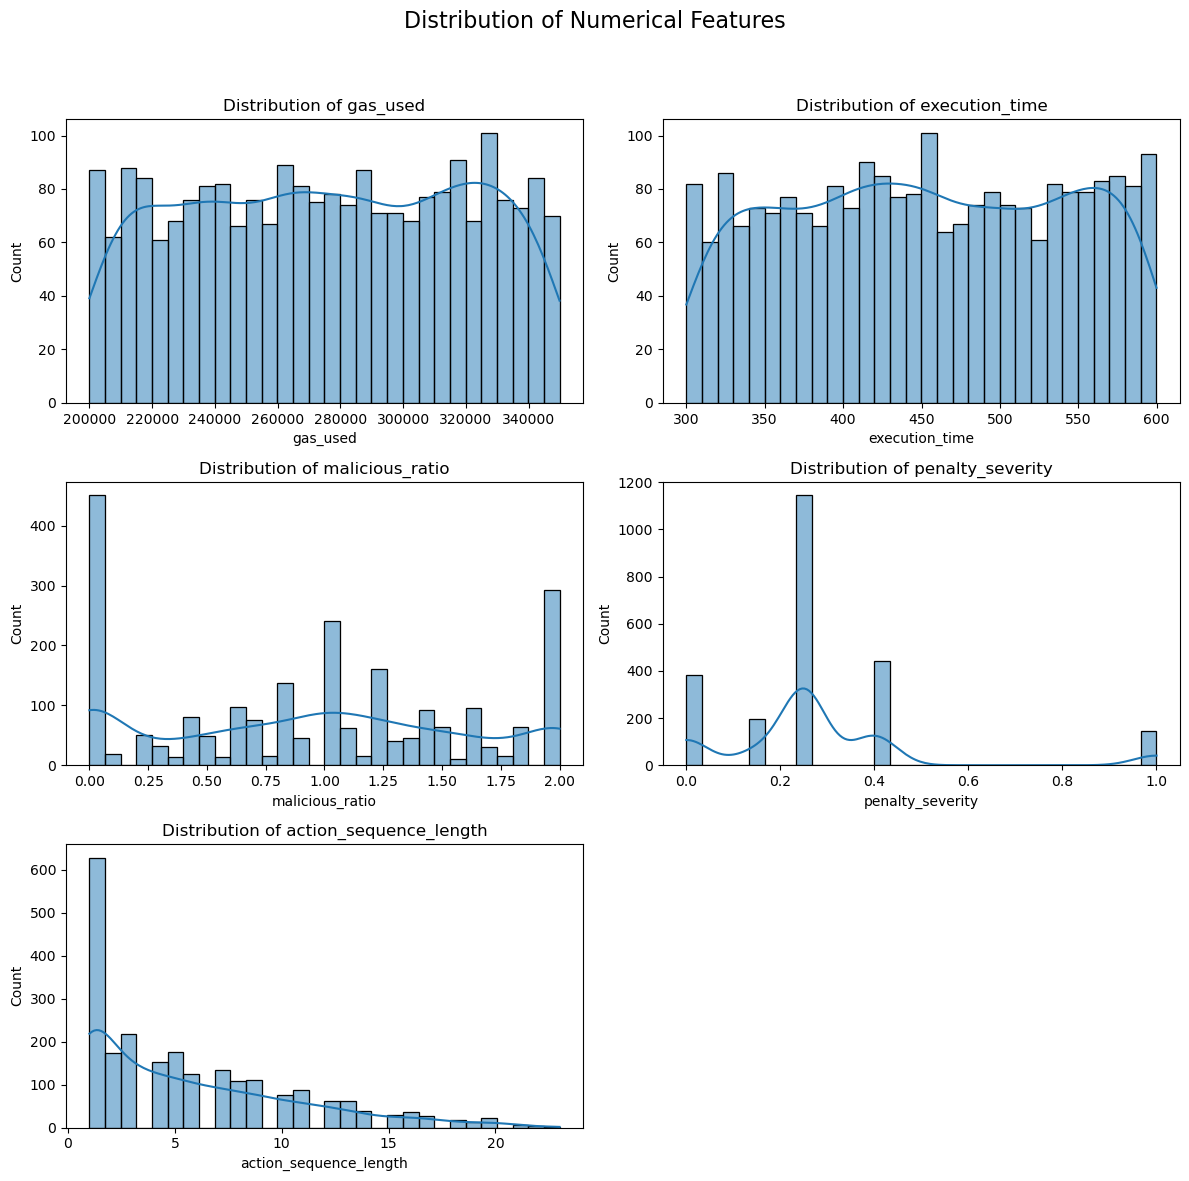

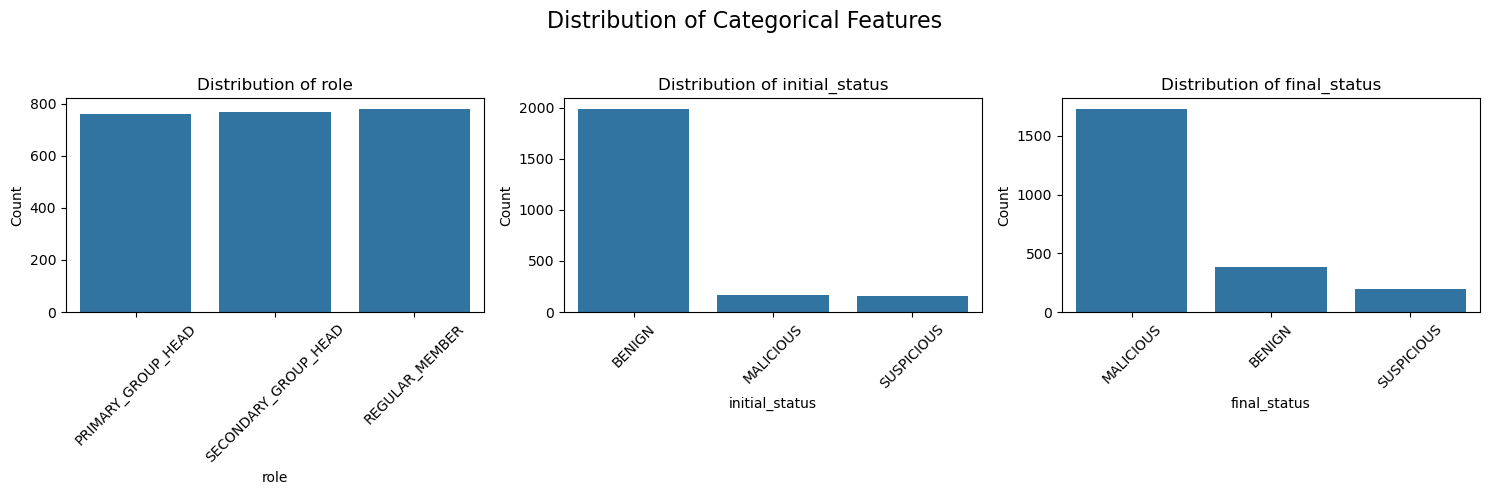

In [4]:
# Numerical features visualization
numerical_cols = ['gas_used', 'execution_time', 'malicious_ratio', 'penalty_severity', 'action_sequence_length']
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
fig.suptitle('Distribution of Numerical Features', fontsize=16)
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

# Remove empty subplot if any
for i in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('numerical_features_distribution.png')
plt.show()

# Categorical features visualization
categorical_cols = ['role', 'initial_status', 'final_status']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig.suptitle('Distribution of Categorical Features', fontsize=16)

for i, col in enumerate(categorical_cols):
    sns.countplot(x=col, data=df, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('categorical_features_distribution.png')
plt.show()


## Features and Preprocessing
We define categorical and numerical features for modeling. Categorical features (role, initial_status, etc.) are one-hot encoded, and numerical features (gas_used, malicious_ratio, etc.) are scaled. The preprocessing pipeline ensures consistent data transformation.

In [5]:
categorical_features = ['role', 'initial_status', 'test_name', 'type', 'role_behavior_interaction']
numerical_features = ['gas_used', 'execution_time', 'balance_before', 'balance_after', 
                     'reward', 'penalty', 'delay', 'is_status_changed', 'action_count', 
                     'recent_malicious', 'time_since_last', 'malicious_ratio', 'action_type_freq', 
                     'time_since_last_penalty', 'penalty_severity', 'action_sequence_length']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

## Prepare Data for Modeling
We extract the feature matrix X and target y (next_behavior). The data is split into training (80%) and testing (20%) sets, with stratification to maintain class distribution. This ensures the models are evaluated on a representative sample.

In [6]:
X = df[categorical_features + numerical_features]
y = df['next_behavior']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Model Training
We train three models: XGBoost, Random Forest, and Logistic Regression. Each model is wrapped in a pipeline with preprocessing and optimized using RandomizedSearchCV to reduce training time while exploring key hyperparameters. The goal is to achieve ~80% accuracy for predicting Benign (0), Suspicious (1), or Malicious (2).

In [7]:
models = {
    'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=500, class_weight='balanced')
}

param_grids = {
    'XGBoost': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [3, 5, 7],
        'classifier__learning_rate': [0.05, 0.1, 0.3],
        'classifier__subsample': [0.8, 1.0]
    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [10, 20, None],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 2]
    },
    'Logistic Regression': {
        'classifier__C': [0.1, 1, 10],
        'classifier__solver': ['lbfgs', 'saga']
    }
}

best_models = {}
for name, model in models.items():
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])
    random_search = RandomizedSearchCV(pipeline, param_grids[name], n_iter=5, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
    random_search.fit(X_train, y_train)
    best_models[name] = random_search.best_estimator_
    print(f"\nBest Parameters for {name}:")
    print(random_search.best_params_)


Best Parameters for XGBoost:
{'classifier__subsample': 0.8, 'classifier__n_estimators': 100, 'classifier__max_depth': 7, 'classifier__learning_rate': 0.05}

Best Parameters for Random Forest:
{'classifier__n_estimators': 200, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 20}

Best Parameters for Logistic Regression:
{'classifier__solver': 'saga', 'classifier__C': 0.1}


## Model Evaluation
We evaluate each model on the test set using accuracy, precision, recall, F1-score (weighted for multi-class), and confusion matrix. Cross-validation scores provide a robust estimate of performance.


Evaluation for XGBoost:
Accuracy: 0.6479
Precision: 0.6434
Recall: 0.6479
F1-Score: 0.6442
Confusion Matrix:
[[143  11  63]
 [ 10  12  17]
 [ 57   5 145]]

Classification Report for XGBoost:
              precision    recall  f1-score   support

      Benign       0.68      0.66      0.67       217
  Suspicious       0.43      0.31      0.36        39
   Malicious       0.64      0.70      0.67       207

    accuracy                           0.65       463
   macro avg       0.58      0.56      0.57       463
weighted avg       0.64      0.65      0.64       463



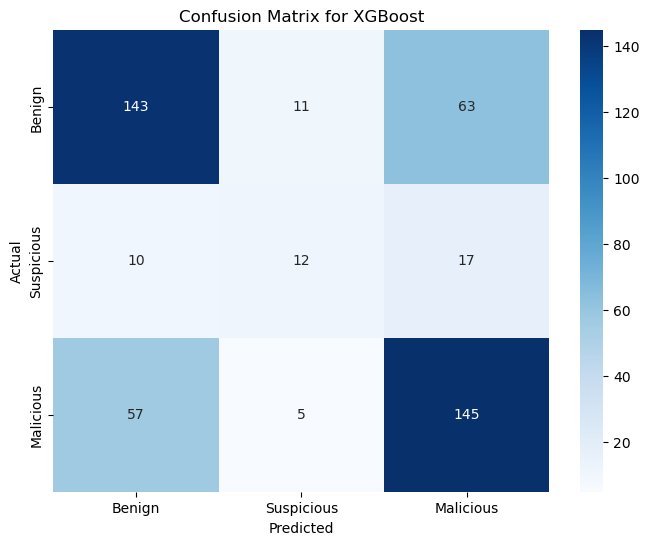

Cross-Validation Accuracy: 0.5906 (±0.0649)

Evaluation for Random Forest:
Accuracy: 0.6674
Precision: 0.6589
Recall: 0.6674
F1-Score: 0.6610
Confusion Matrix:
[[151  10  56]
 [  8   9  22]
 [ 53   5 149]]

Classification Report for Random Forest:
              precision    recall  f1-score   support

      Benign       0.71      0.70      0.70       217
  Suspicious       0.38      0.23      0.29        39
   Malicious       0.66      0.72      0.69       207

    accuracy                           0.67       463
   macro avg       0.58      0.55      0.56       463
weighted avg       0.66      0.67      0.66       463



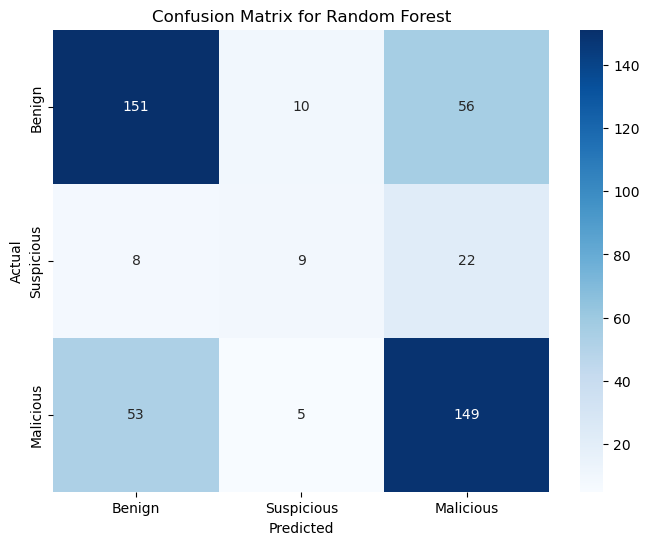

Cross-Validation Accuracy: 0.5962 (±0.0637)

Evaluation for Logistic Regression:
Accuracy: 0.5875
Precision: 0.6786
Recall: 0.5875
F1-Score: 0.6158
Confusion Matrix:
[[132  48  37]
 [  6  26   7]
 [ 45  48 114]]

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

      Benign       0.72      0.61      0.66       217
  Suspicious       0.21      0.67      0.32        39
   Malicious       0.72      0.55      0.62       207

    accuracy                           0.59       463
   macro avg       0.55      0.61      0.54       463
weighted avg       0.68      0.59      0.62       463



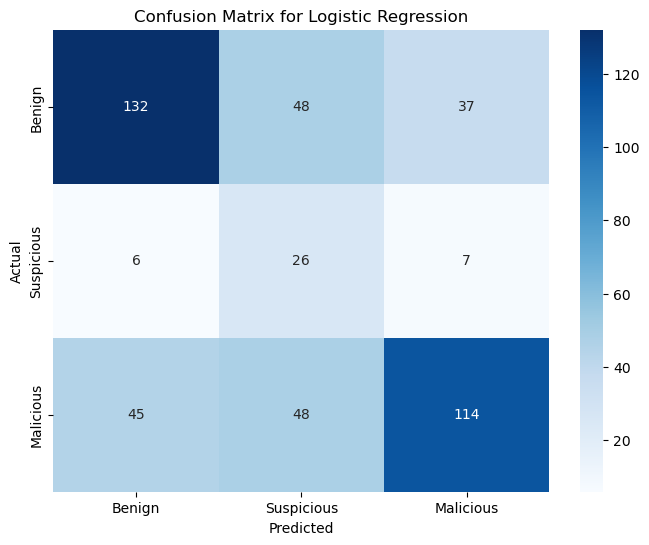

Cross-Validation Accuracy: 0.5543 (±0.0691)


In [8]:
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    print(f"\nEvaluation for {name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    
    # Generate classification report
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred, target_names=['Benign', 'Suspicious', 'Malicious']))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Benign', 'Suspicious', 'Malicious'], 
                yticklabels=['Benign', 'Suspicious', 'Malicious'])
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f'confusion_matrix_{name.lower().replace(" ", "_")}.png')
    plt.show()
    
    cv_scores = cross_val_score(model, X, y, cv=3, scoring='accuracy', n_jobs=-1)
    print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

## Feature Importance for Tree-Based Models
For XGBoost and Random Forest, we extract and visualize the top 10 most important features. This helps understand which features (e.g., recent_malicious, malicious_ratio) drive predictions.

In [9]:
for name in ['XGBoost', 'Random Forest']:
    model = best_models[name]
    feature_names = (model.named_steps['preprocessor']
                     .transformers_[0][1]
                     .get_feature_names_out(categorical_features)
                     .tolist() + numerical_features)
    importances = model.named_steps['classifier'].feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    print(f"\nTop 5 Feature Importances for {name}:")
    print(feature_importance_df.head())
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
    plt.title(f'Top 10 Feature Importances for {name}')
    plt.tight_layout()
    plt.savefig(f'feature_importance_{name.lower().replace(" ", "_")}.png')
    plt.close()


Top 5 Feature Importances for XGBoost:
                          Feature  Importance
11  test_name_too_frequent_access    0.102590
41                malicious_ratio    0.050535
39               recent_malicious    0.045868
19                     type_type2    0.035114
45         action_sequence_length    0.034757

Top 5 Feature Importances for Random Forest:
                    Feature  Importance
41          malicious_ratio    0.107212
39         recent_malicious    0.091947
43  time_since_last_penalty    0.081568
45   action_sequence_length    0.069851
42         action_type_freq    0.064406


## Predict Next Behavior for a Sample User
We select a random user from the dataset and predict their next behavior (Benign, Suspicious, or Malicious) using each model, displaying class probabilities.

In [35]:
import random

# Select a random user
random_idx = random.randint(0, len(X) - 1)
random_user = X.iloc[random_idx:random_idx+1].copy()

behavior_map = {0: 'Benign', 1: 'Suspicious', 2: 'Malicious'}
for name, model in best_models.items():
    random_pred = model.predict(random_user)
    random_prob = model.predict_proba(random_user)
    
    print(f"\nSample User Prediction with {name}:")
    print(f"Features: {random_user.to_dict(orient='records')[0]}")
    print(f"Predicted Next Behavior: {behavior_map[random_pred[0]]}")
    print(f"Probability (Benign, Suspicious, Malicious): {random_prob[0]}")


Sample User Prediction with XGBoost:
Features: {'role': 'PRIMARY_GROUP_HEAD', 'initial_status': 'MALICIOUS', 'test_name': 'unauthorized_global_access', 'type': 'type1', 'role_behavior_interaction': 'PRIMARY_GROUP_HEAD_2', 'gas_used': 227938, 'execution_time': 543.72, 'balance_before': 1e+24, 'balance_after': 1e+24, 'reward': 0, 'penalty': 5000, 'delay': 3600, 'is_status_changed': 0, 'action_count': 4, 'recent_malicious': 6.0, 'time_since_last': 92.000023, 'malicious_ratio': 2.0, 'action_type_freq': 0.375, 'time_since_last_penalty': 18000.0, 'penalty_severity': 0.25, 'action_sequence_length': 1}
Predicted Next Behavior: Malicious
Probability (Benign, Suspicious, Malicious): [0.05068846 0.0293304  0.9199811 ]

Sample User Prediction with Random Forest:
Features: {'role': 'PRIMARY_GROUP_HEAD', 'initial_status': 'MALICIOUS', 'test_name': 'unauthorized_global_access', 'type': 'type1', 'role_behavior_interaction': 'PRIMARY_GROUP_HEAD_2', 'gas_used': 227938, 'execution_time': 543.72, 'balanc